# Optionnal Homework 2

---

In a new python environment with python>=3.10

In [ ]:
!pip install "torch_uncertainty[image] @ git+https://github.com/ENSTA-U2IS-AI/torch-uncertainty@dev" -q

In [ ]:
# here are the training parameters
batch_size = 10
learning_rate =1e-3
weight_decay=2e-4
lr_decay_epochs=20
lr_decay=0.1
nb_epochs=50

In [ ]:
import torch
from einops import rearrange
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F

from torch_uncertainty.datasets import MUAD

train_transform = v2.Compose(
    [
        v2.Resize(size=(256, 512), antialias=True),
        v2.RandomHorizontalFlip(),
        v2.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,
                tv_tensors.Mask: torch.int64,
                "others": None,
            },
            scale=True,
        ),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        v2.Resize(size=(256, 512), antialias=True),
        v2.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,
                tv_tensors.Mask: torch.int64,
                "others": None,
            },
            scale=True,
        ),
        v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

train_set = MUAD(root="./data", target_type="semantic", version="small", split="train" , transforms=train_transform, download=True)
val_set = MUAD(root="./data", target_type="semantic", version="small", split="val" , transforms=val_transform, download=True)
test_set = MUAD(root="./data", target_type="semantic", version="small", split="test" , transforms=val_transform, download=True)

Let us see the first sample of the validation set. The first image is the input and the second image is the target (ground truth).

In [ ]:
sample = train_set[0]
img, tgt = sample
img.size(), tgt.size()

(torch.Size([3, 256, 512]), torch.Size([1, 256, 512]))

Visualize a validation input sample (and RGB image).

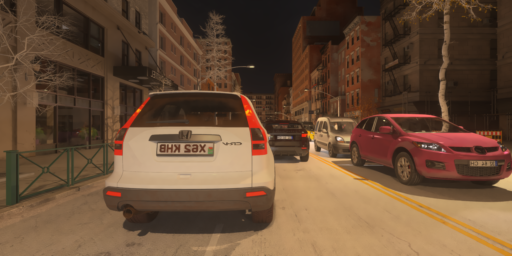

In [ ]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)
F.to_pil_image(img)

Visualize the same image above but segmented (our goal).

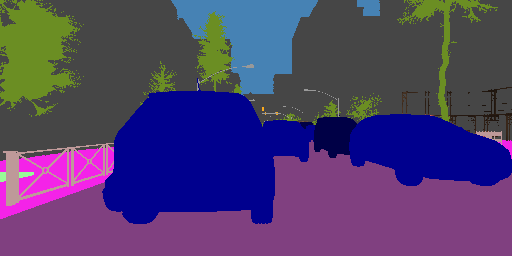

In [ ]:
from torchvision.utils import draw_segmentation_masks

tmp_tgt = tgt.masked_fill(tgt == 255, 22)
tgt_masks = tmp_tgt == torch.arange(22, device=tgt.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, tgt_masks, alpha=1, colors=val_set.color_palette)
F.to_pil_image(img_segmented)

Below is the complete list of classes in MUAD, presented as:

1.   Class Name
2.   Train ID
3.   Segmentation Color in RGB format [R,G, B].

In [ ]:
for muad_class in train_set.classes:
    class_name = muad_class.name
    train_id = muad_class.id
    color = muad_class.color
    print(f"Class: {class_name:20} | Train ID: {train_id:2} | Color: {color}")

Class: road, Train ID: 0, Color: (128, 64, 128)
Class: sidewalk, Train ID: 1, Color: (244, 35, 232)
Class: building, Train ID: 2, Color: (70, 70, 70)
Class: wall, Train ID: 3, Color: (102, 102, 156)
Class: fence, Train ID: 4, Color: (190, 153, 153)
Class: pole, Train ID: 5, Color: (153, 153, 153)
Class: traffic_light, Train ID: 6, Color: (250, 170, 30)
Class: traffic_sign, Train ID: 7, Color: (220, 220, 0)
Class: vegetation, Train ID: 8, Color: (107, 142, 35)
Class: terrain, Train ID: 9, Color: (152, 251, 152)
Class: sky, Train ID: 10, Color: (70, 130, 180)
Class: person, Train ID: 11, Color: (220, 20, 60)
Class: rider, Train ID: 12, Color: (255, 0, 0)
Class: car, Train ID: 13, Color: (0, 0, 142)
Class: truck, Train ID: 14, Color: (0, 0, 70)
Class: bus, Train ID: 15, Color: (0, 60, 100)
Class: train, Train ID: 16, Color: (0, 80, 100)
Class: motorcycle, Train ID: 17, Color: (0, 0, 230)
Class: bicycle, Train ID: 18, Color: (119, 11, 32)
Class: bear deer cow, Train ID: 19, Color: (255, 22

Here is a more comprhensive review of the diffrent classes : (while training Non-labeled data will use train ID 21 and not 255)


| **class names**                       | **ID** |
|----------------------------------------|---------|
| road                                   | 0       |
| sidewalk                               | 1       |
| building                               | 2       |
| wall                                   | 3       |
| fence                                  | 4       |
| pole                                   | 5       |
| traffic light                          | 6       |
| traffic sign                           | 7       |
| vegetation                             | 8       |
| terrain                                | 9       |
| sky                                    | 10      |
| person                                 | 11      |
| rider                                  | 12      |
| car                                    | 13      |
| truck                                  | 14      |
| bus                                    | 15      |
| train                                  | 16      |
| motorcycle                             | 17      |
| bicycle                                | 18      |
| bear deer cow                          | 19      |
| garbage_bag stand_food trash_can       | 20      |


We will feed our DNN the first raw image of the road view and as target it will be the dark image below and not the colored one (second image)

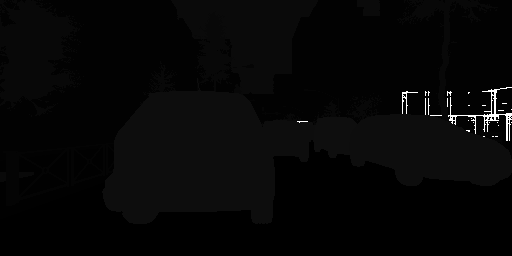

In [ ]:
im = F.to_pil_image(F.to_dtype(tgt, torch.uint8))
im

In [ ]:
im.size

(512, 256)

**Q2/ Why is the target image dark and what's the bright part? (hint: print the numpy array)**

In [ ]:
import numpy as np

tgt_img = np.array(im)
print(np.unique(tgt_img, return_counts = True))

(array([  0,   1,   2,   4,   5,   6,   8,   9,  10,  13,  14, 255],
      dtype=uint8), array([33149,  3673, 44197,  1917,   162,    14,  9913,   129,  7382,
       28471,  1393,   672]))


**ANSWER:** The target image corresponds to class labels. So the image contains integers representing the class attributed to each pixel. The bright part corresponds to the non-labeled data, that originally has the label-value 255. This value being much higher than the others (from 0 to 21) we can not distinguish the other shapes and see just a dark image.


**Q3/ Study the dataset a bit. What it is about?**



**ANSWER:** This dataset contains pair of images. The first image correponds to photos from a camera fixed at the front of a car in different situations. It seems that the environments in which the car evolves are mostly cities (roads, buildings, pedestrians, cars, trees...). The second "image" contains the label of each pixel from the first image: a single value is attributed to all pixels that are part of an object (roads, buildings, pedestrians, cars, trees...). If an object is not in the predefined list of recognized object a default value is attributed.  
This might be an usefull dataset for problematics like autonomous driving.

In [ ]:
import matplotlib.pyplot as plt

def visualize_sample(sample):

  img, tgt = sample

  # Undo normalization on the image and convert to uint8.
  mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
  std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
  img = img * std[:, None, None] + mean[:, None, None]
  img = F.to_dtype(img, torch.uint8, scale=True)
  show_img = F.to_pil_image(img)

  tmp_tgt = tgt.masked_fill(tgt == 255, 22)
  tgt_masks = tmp_tgt == torch.arange(22, device=tgt.device)[:, None, None]
  img_segmented = draw_segmentation_masks(img, tgt_masks, alpha=1, colors=val_set.color_palette)
  show_img_segmented = F.to_pil_image(img_segmented)

  show_raw_seg = F.to_pil_image(F.to_dtype(tgt, torch.uint8))

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))
  ax1.imshow(show_img)
  ax2.imshow(show_raw_seg, cmap='gray')
  ax3.imshow(show_img_segmented)
  ax1.set_title('Input image')
  ax2.set_title('Ground truth')
  ax3.set_title('Segmented image colorized')
  plt.show()

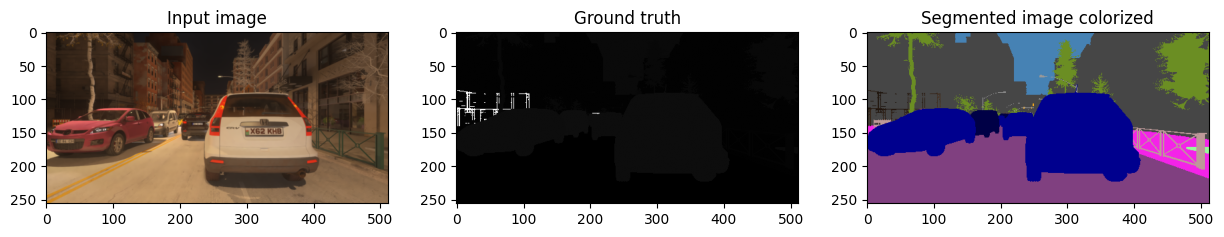

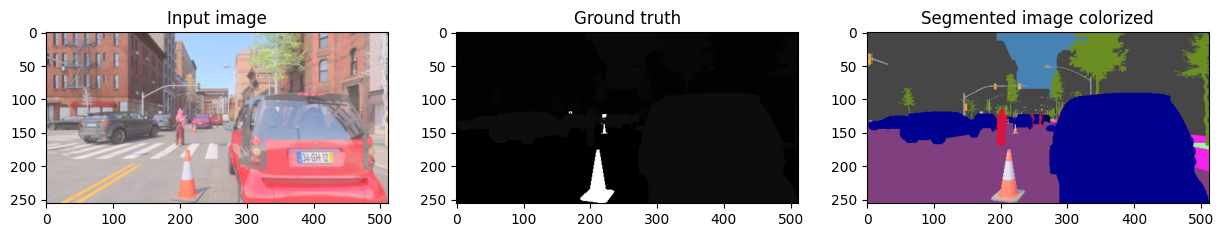

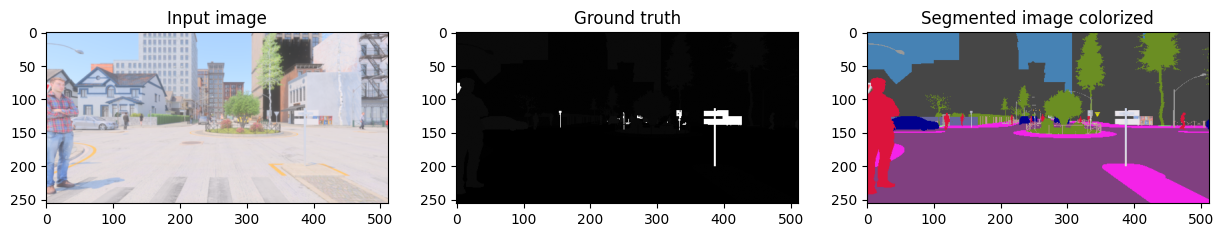

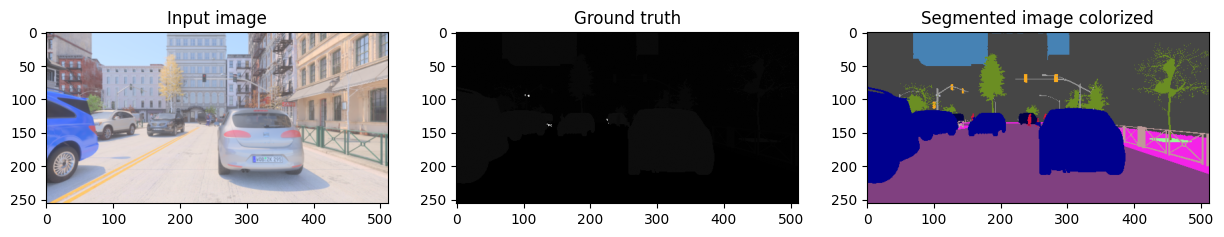

In [ ]:
for i in range(0, len(train_set), 100):
  visualize_sample(train_set[i])


In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader

train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4)

val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4)

test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4)


In [ ]:
def enet_weighing(dataloader, num_classes, c=1.02):
    """Computes class weights as described in the ENet paper.

        w_class = 1 / (ln(c + p_class)),

    where c is usually 1.02 and p_class is the propensity score of that
    class:

        propensity_score = freq_class / total_pixels.

    References:
        https://arxiv.org/abs/1606.02147

    Args:
        dataloader (``data.Dataloader``): A data loader to iterate over the
            dataset.
        num_classes (``int``): The number of classes.
        c (``int``, optional): AN additional hyper-parameter which restricts
            the interval of values for the weights. Default: 1.02.

    """
    class_count = 0
    total = 0
    for _, label in dataloader:
      label = label.cpu().numpy()
      # Flatten label
      flat_label = label.flatten()
      flat_label = flat_label[flat_label != 255]

      # Sum up the number of pixels of each class and the total pixel
      # counts for each label
      class_count += np.bincount(flat_label, minlength=num_classes)
      total += flat_label.size

    # Compute propensity score and then the weights for each class
    propensity_score = class_count / total
    return 1 / (np.log(c + propensity_score))

In [ ]:
%%script false --no-raise-error
print("Computing class weights...")
print("(this can take a while depending on the dataset size)")
class_weights = enet_weighing(train_loader, 19)
class_weights = torch.from_numpy(class_weights).float().cuda()
print("Class weights:", class_weights)

In [ ]:
# Hardcoding class weights
class_weights = torch.tensor([ 4.1643, 18.8984,  3.2313, 48.7521, 34.9159, 33.8659, 46.7701, 49.3670, 12.2677, 48.3328, 14.2019, 32.0444, 50.4983,  5.2256, 21.1894, 50.4983, 50.4983, 50.4983, 50.4983], device='cuda:0')

In [ ]:
for i, muad_class in enumerate(train_set.classes[:19]):
    class_name = muad_class.name
    train_id = muad_class.id
    print(f"Class: {class_name:20} | Train ID: {train_id:2} | Weight: {class_weights[i]}")

Class: road                 | Train ID:  0 | Weight: 4.164299964904785
Class: sidewalk             | Train ID:  1 | Weight: 18.898399353027344
Class: building             | Train ID:  2 | Weight: 3.231300115585327
Class: wall                 | Train ID:  3 | Weight: 48.75210189819336
Class: fence                | Train ID:  4 | Weight: 34.91590118408203
Class: pole                 | Train ID:  5 | Weight: 33.86589813232422
Class: traffic_light        | Train ID:  6 | Weight: 46.77009963989258
Class: traffic_sign         | Train ID:  7 | Weight: 49.367000579833984
Class: vegetation           | Train ID:  8 | Weight: 12.2677001953125
Class: terrain              | Train ID:  9 | Weight: 48.332801818847656
Class: sky                  | Train ID: 10 | Weight: 14.201899528503418
Class: person               | Train ID: 11 | Weight: 32.04439926147461
Class: rider                | Train ID: 12 | Weight: 50.49829864501953
Class: car                  | Train ID: 13 | Weight: 5.225599765777588
Cla

The weight attributed to each class seems coherent. Very frequent classes like road (that take a lot of space on the images) have a small weight whereas less frequent classes have a higher weight.

**Q4/ Why do we need to evaluate the class_weights?**

**ANSWER:** Notice that the more the class is frequent, the smaller its weight is. Evaluating the class_weights is crucial to handle Class Imbalance: the classes are not equally represented, we might have a lot of pixels for "road" or "building" and a few for "fence" (very thin structures).  
Thus, we will be able to affect higher importance to those low represented classes, to help the model to perform as well as for the others.  
Without using class weights to balance classes, the model might learn not to predict classes that are less probable/represented in the data because they do not impact the loss a lot. In the worst case scenario: the model learns to predict only the most frequent class in the dataset because it is the correct prediction most of the times...

## C. Building the DNN

**Q5/ Do we really use Unet? What did I change? (that is hard)**









**ANSWER:** The architecture is really similar to the U-Net architecture proposed in [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597), with the encoder-decoder shape and the double convolutions.  
Yet there is a few things that differs from the typical Unet. The number of channels in not the same (generally half of what was originally proposed).According to the same paper, there is no batch normalisation. The comment in the code snippet says dropout layers are only here to use Monte-Carlo dropout for model uncertainty evaluation. Also, the alternative for Up-Blocks instead of convolutions (performed with nn.ConvTranspose2d)  is a possible difference. The basic architecture does not involve bilinear upsampling.

**Q6/ Do we need a backbone with Unet?**



**ANSWER:** UNet does not require the usage of a backbone since the feature extraction is efficiently performed in the encoder part. However, it is possible to use a backbone for the encoder part to improve the overall model performance.  
No backbone is used in this practical work, the U-Net model is trained from scratch.

In [ ]:
from torch import nn

class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2."""

    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        return self.mpconv(x)


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        self.bilinear = bilinear

        self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        if self.bilinear:
            x1 = F.resize(x1, size=[2*x1.size()[2],2*x1.size()[3]],
                          interpolation=v2.InterpolationMode.BILINEAR)
        else:
            x1 = self.up(x1)

        # input is CHW
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        return self.conv(x)

#please note that we have added dropout layer to be abble to use MC dropout

class UNet(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.inc = InConv(3, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 256)
        self.up1 = Up(512, 128)
        self.up2 = Up(256, 64)
        self.up3 = Up(128, 32)
        self.up4 = Up(64, 32)
        self.dropout = nn.Dropout2d(0.1)
        self.outc = OutConv(32, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.dropout(x)
        x = self.up2(x, x3)
        x = self.dropout(x)
        x = self.up3(x, x2)
        x = self.dropout(x)
        x = self.up4(x, x1)
        x = self.dropout(x)
        return self.outc(x)

## D. Utility functions

In [ ]:
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_accu(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training miou", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation miou", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Mean IoU")
    plt.legend(loc="upper right")
    plt.title("Evolution of Miou")
    plt.show()

**Q7/ What is the IoU?**


**ANSWER:** IoU (Intersection over Union) is a common measure of accuracy for segmentations tasks, as it allows to compare 2 regions.    
It is computed as a ratio of the number of pixels that the two regions share over the sum of the pixels from both regions (pixels belonging to the two are counted only once).

$$
\text{IoU}(A, B) = \frac{|A \cap B| }{|A \cup B|}
$$

Its maximum value is **1** (our target, both regions are the same), and the minimum is **0**, if they don't share any pixel.  

In our case, it measures the overlap between two bounding boxes: the predicted bounding box (from the model) and the ground truth bounding box (the actual object location).

### Training function

**Q8/ Complete the training and the test function.**

In [ ]:
from torchmetrics.utilities.compute import _safe_divide

def train(model, data_loader, optim, criterion, metric, iteration_loss=False):
    model.train()
    epoch_loss = 0.0
    metric.reset()
    for step, batch_data in enumerate(data_loader):
        # Get the inputs and labels
        img = batch_data[0].cuda()
        labels = batch_data[1].cuda()

        # Forward propagation
        logits = model(img)

        flatten_logits =  rearrange(logits, 'b c h w -> (b h w) c')
        flatten_labels = rearrange(labels, 'b c h w -> (b c h w)')

        valid_mask = flatten_labels != 255

        # Loss computation
        loss = criterion(flatten_logits[valid_mask], flatten_labels[valid_mask])

        # Backpropagation
        optim.optimizer.zero_grad()
        loss.backward()
        optim.optimizer.step()

        # Keep track of loss for current epoch
        epoch_loss += loss.item()

        # Keep track of the evaluation metric
        metric.update(flatten_logits[valid_mask].detach(), flatten_labels[valid_mask].detach())

        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))

    return epoch_loss / len(data_loader), iou_per_class, metric.compute()

In [ ]:
def test(model, data_loader, criterion, metric, iteration_loss=False):
    model.eval()
    epoch_loss = 0.0
    metric.reset()
    for step, batch_data in enumerate(data_loader):
        # Get the inputs and labels
        img = batch_data[0].cuda()
        labels = batch_data[1].cuda()

        with torch.no_grad():
            # Forward propagation
            logits = model(img)

            flatten_logits =  rearrange(logits, 'b c h w -> (b h w) c')
            flatten_labels = rearrange(labels, 'b c h w -> (b c h w)')

            valid_mask = flatten_labels != 255

            # Loss computation
            loss = criterion(flatten_logits[valid_mask], flatten_labels[valid_mask])

        # Keep track of loss for current epoch
        epoch_loss += loss.item()

        # Keep track of evaluation the metric
        metric.update(flatten_logits[valid_mask].detach(), flatten_labels[valid_mask].detach())

        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))

    return epoch_loss / len(data_loader), iou_per_class, metric.compute()

## E. Training Process

**Q9/ Train your DNN and comment.**



In [ ]:
from torch import optim
from torch.optim import lr_scheduler

from torch_uncertainty.metrics.classification import MeanIntersectionOverUnion

print("Training...")
num_classes = 19
# Intialize UNet
model = UNet(num_classes).cuda()
optim = lr_scheduler.StepLR(optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay),
                            step_size=lr_decay_epochs, gamma=lr_decay)

# We are going to use the CrossEntropyLoss loss function as it's most
# frequentely used in classification problems with multiple classes which
# fits the problem. This criterion  combines LogSoftMax and NLLLoss.
criterion = nn.CrossEntropyLoss(weight=class_weights)
metric = MeanIntersectionOverUnion(num_classes=num_classes).cuda()



Training...



In [ ]:
%%script false --no-raise-error
# Start Training
classes = [muad_class.name for muad_class in train_set.classes]

train_loss_history = []
train_miou_history = []
val_loss_history = []
val_miou_history = []
best_miou = 0
for epoch in range(nb_epochs):
  print(f"[Epoch {epoch + 1}/{nb_epochs}] Training...")
  train_loss, train_iou, train_miou = train(model, train_loader, optim, criterion, metric)
  print(f"\tAvg. loss: {train_loss:.4f} | Mean IoU: {train_miou:.4f}")
  train_loss_history.append(train_loss)
  train_miou_history.append(train_miou.cpu())


  print(f"[Epoch {epoch + 1}/{nb_epochs}] Validation...")
  val_loss, val_iou, val_miou = test(model, val_loader, criterion, metric)
  print(f"Avg. loss: {val_loss:.4f} | Mean IoU: {val_miou:.4f}")
  val_loss_history.append(val_loss)
  val_miou_history.append(val_miou.cpu())

  if val_miou > best_miou:
      best_miou = val_miou
      print(f'\nBest model so far. Saving...')
      torch.save(model.state_dict(), "model.pth")
      print(f'>>> Model saved to model.pth\n')

  if (epoch+1) % 5 == 0:
    for name, val in zip(classes, val_iou):
      print(f"{name}: {val:.4f}")

  optim.step()

**ANSWER:** The loss and MIOU evolve correctly during training, but seems to plateau.  
We can indeed observe that it performs well for classes like *road*, *building*, *sidewalk* or *sky*, that are very large and frequent objects in the dataset. In the other hand, for classes like *bicycle* or *traffic_sign*, the IoU is equal to 0, which means that it can not segment these objects, wchich could be an issue for autonomous driving (we really need to detect traffic sign for example...).  
We also notice 'nan' values, from classes undetected by the model.  

In [ ]:
# Empty cuda cache
torch.cuda.empty_cache()

# Loading a model
model = UNet(19)
model.load_state_dict(torch.load("model.pth"))
model = model.to("cuda")

/tmp/ipykernel_1114719/1554282114.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


In [ ]:
# Hardcode the values of *_history to avoid retraining the model everytime
train_loss_history = [2.2473485499620436, 1.6780515879392623, 1.4194012016057969, 1.264488422870636, 1.1599774911999703, 1.074610435962677, 0.9999868690967559, 0.9770675659179687, 0.9134991452097893, 0.8610195919871331, 0.8516210868954659, 0.8390827164053917, 0.7878137409687043, 0.8071925848722458, 0.7699194505810738, 0.7262567117810249, 0.7088780850172043, 0.674629008024931, 0.6449406340718269, 0.6568144604563713, 0.6280481971800327, 0.5511902056634426, 0.5355789676308632, 0.5351346172392368, 0.5183741316199303, 0.5137156188488007, 0.504043385386467, 0.5118143133819103, 0.49522377997636796, 0.4794100381433964, 0.4863883890211582, 0.48382545337080957, 0.4855225495994091, 0.4659111887216568, 0.46257380619645116, 0.4566795326769352, 0.4476388990879059, 0.44936819449067117, 0.44346368610858916, 0.435233061760664, 0.42917445823550227, 0.42052445709705355, 0.42285059466958047, 0.4174689404666424, 0.4158480755984783, 0.4164981946349144, 0.4164991036057472, 0.40919115766882896, 0.40842429026961324, 0.4112710699439049]
train_miou_history = [0.0984, 0.2098, 0.2320, 0.2685, 0.2872, 0.3011, 0.3146, 0.3195, 0.3304, 0.3363, 0.3413, 0.3483, 0.3575, 0.3555, 0.3632, 0.3791, 0.3852, 0.3908, 0.4023, 0.3990, 0.4019, 0.4358, 0.4433, 0.4422, 0.4489, 0.4529, 0.4518, 0.4572, 0.4580, 0.4638, 0.4655, 0.4661, 0.4629, 0.4722, 0.4769, 0.4787, 0.4824, 0.4857, 0.4820, 0.4956, 0.4966, 0.5053, 0.5010, 0.5022, 0.5001, 0.5034, 0.5051, 0.5060, 0.5098, 0.5078]
val_loss_history = [2.033372163772583, 1.6665048201878865, 1.3912177681922913, 1.3765389323234558, 1.1687066356341045, 1.0963793396949768, 1.1447117030620575, 1.0115756491820018, 1.0035091539223988, 1.0077890853087108, 1.021950791279475, 0.9443629582722982, 0.8566581308841705, 0.7897069950898489, 0.794803112745285, 0.8532017767429352, 0.8749309877554575, 0.7270745386679968, 0.8355667094389597, 0.9586826860904694, 0.6484342763821284, 0.61300228536129, 0.5891900708278021, 0.6068841318289439, 0.5794899215300878, 0.5751466055711111, 0.5749695152044296, 0.5850738883018494, 0.5484730998675028, 0.5548795064290365, 0.5769242296616236, 0.5515630145867666, 0.5921135445435842, 0.592729464173317, 0.5668985148270925, 0.5571275105079015, 0.523540273308754, 0.5416185011466345, 0.543817142645518, 0.557752658923467, 0.5437288731336594, 0.5473254919052124, 0.545221154888471, 0.5455946127573649, 0.5418725907802582, 0.5535779943068823, 0.541535864273707, 0.5536083082358042, 0.5537281682093939, 0.5499341189861298]
val_miou_history = [0.1439, 0.1859, 0.2218, 0.2100, 0.2672, 0.2796, 0.2792, 0.2981, 0.2963, 0.2844, 0.3136, 0.3085, 0.3346, 0.3414, 0.3415, 0.3446, 0.3226, 0.3722, 0.3236, 0.3034, 0.3943, 0.4055, 0.4074, 0.4028, 0.4159, 0.4171, 0.4162, 0.4202, 0.4214, 0.4246, 0.4169, 0.4266, 0.4224, 0.4259, 0.4318, 0.4340, 0.4300, 0.4329, 0.4301, 0.4440, 0.4445, 0.4407, 0.4420, 0.4468, 0.4413, 0.4429, 0.4485, 0.4430, 0.4434, 0.4467]

# III. Evalution of the Trained DNN on the test

## A. classical evaluations

**Q10/ Plot the loss and miou and comment about it?**

**Already in the notebook (not our answer):** Both the training and test loss curves show a similar downward trend, stabilizing around 0.3. However, there's a notable difference in the mean Intersection over Union (mIoU) values: the training mIoU reaches approximately 0.75, whereas the test mIoU plateaus at around 0.65. This discrepancy indicates a definite overfitting to the training dataset.


**ANSWER:** As explained, the loss and the mIoU respectively increase and dicrease. They do not reach the expected values (0.3 for the losses and 0.65/0.75 for the mIoU), but it is probably because of the number of epochs: it looks like they could evolve a bit more, but we did not have time to train the model on more epochs than the given value (50).  

We still observe that the model tends to overfit.

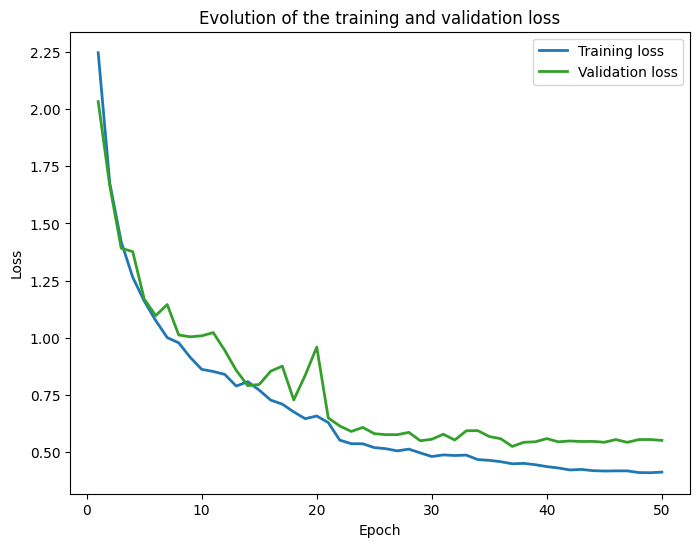

In [ ]:
plot_losses(train_loss_history, val_loss_history)

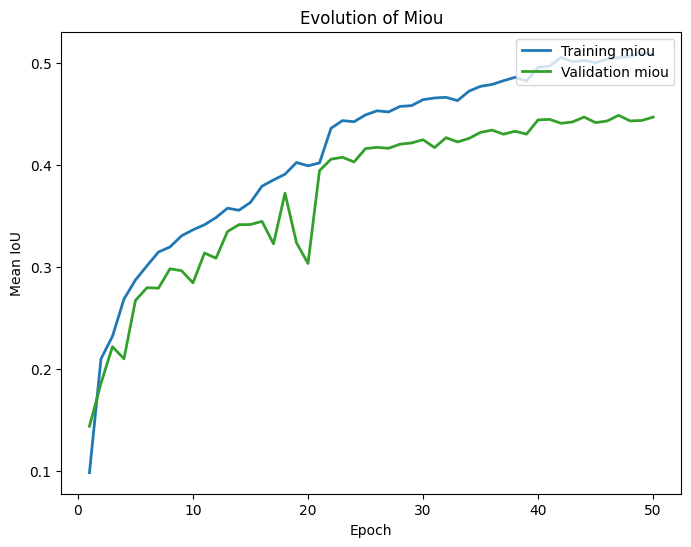

In [ ]:
plot_accu(train_miou_history, val_miou_history)

**Q11/ What should we have done to avoid overfitting?**



**ANSWER:** Overfitting often occurs when the model has too few training examples. One solution to avoid overfitting could be to train the model on more data either by increasing the dataset size with new real samples or by using data augmentation techniques such as applying linear transformation (like shift, rotatation or flip) to images for instance.

There was a debate between us about other techniques such as color shifting or adding noise or blur (motion blur, gaussian blur...).  
On one hand, it might cause issue in the context of autonomous driving.  
But in the other hand, those degradations could reproduce some comportements of the images: they could indeed have different degree of quality, depending on the condititions for examples like autonomous driving: the other cars or pedestrians are moving subject, so they might be in deplacement and create blur.

Regularisation is also a good way to avoid overfitting. It can be viewed as simplifying the model in a random way and smaller models are less prone to overfitting.

Early stopping is also a great idea. In this case, it could be use to stop the training as soon as the loss stabilises. However, one downside of early stopping is that any potential loss drop is out of reach (reaching a new local minimum after a couple of epochs).

In [ ]:
# Now we evaluate the model on all the test set.
loss, iou, miou = test(model, test_loader, criterion, metric)
print(">>>> [FINAL TEST on the test set: ] Avg. loss: ", loss ," | Mean IoU: ", miou)
# Print per class IoU on last epoch or if best iou*

class_encoding = {}
for i,muad_class in enumerate(train_set.classes):
  if i >= 19:
    continue
  class_encoding[muad_class.name] = muad_class.id

for key, class_iou in zip(class_encoding.keys(), iou, strict=True):
  print(f"{key}: {class_iou:.4f}")

>>>> [FINAL TEST on the test set: ] Avg. loss:  0.5481520965695381  | Mean IoU:  tensor(0.4870, device='cuda:0')
road: 0.9421
sidewalk: 0.7274
building: 0.8017
wall: 0.4873
fence: 0.4115
pole: 0.2242
traffic_light: 0.1424
traffic_sign: 0.0000
vegetation: 0.6081
terrain: 0.0104
sky: 0.9157
person: 0.4089
rider: nan
car: 0.7502
truck: 0.3881
bus: nan
train: nan
motorcycle: nan
bicycle: nan


## B. Uncertainty evaluations with MCP
Here you will just use as confidence score the Maximum class probability (MCP).


In [ ]:
sample_idx = 0
img, target = test_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
model.eval()
with torch.no_grad():
	# Forward propagation
	outputs = model(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	# remove the batch dimension
	outputs_proba = outputs_proba.squeeze(0)
	confidence, pred = outputs_proba.max(0)

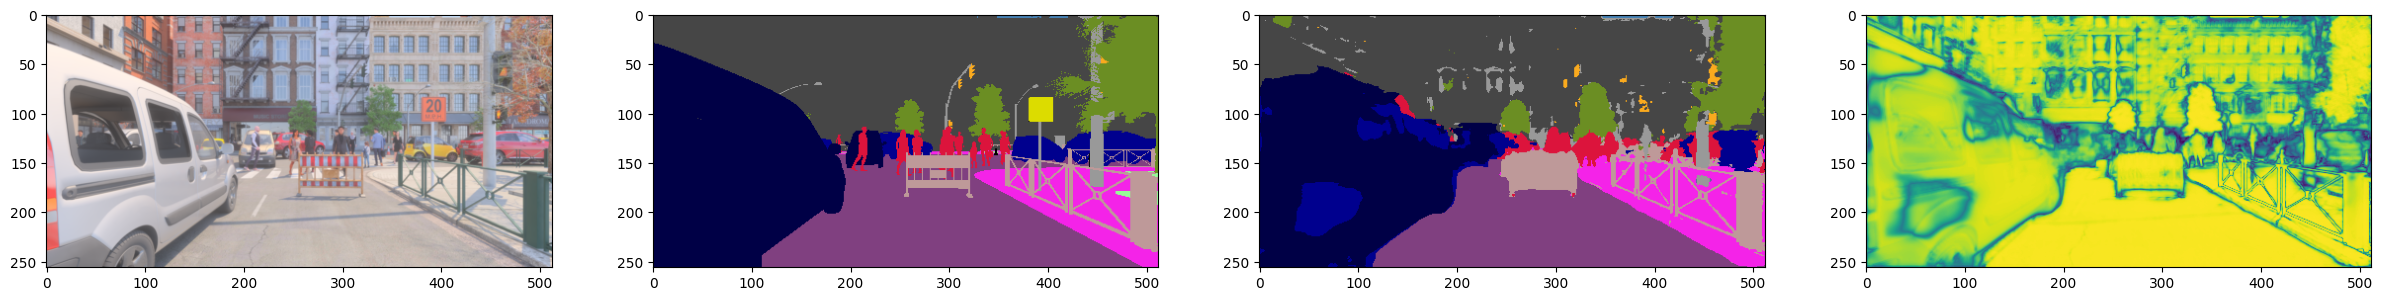

In [ ]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**Q12/ The last image is the related to the confidence score of the DNN. Can you explain why? What does the birght areas represent and what does the dark areas represent?**


**ANSWER:** From left to right, the first image is the input image and the second image is the target, that is to say the input image perfectly segmented.  
The third image represents the segmentation made by the model.  The segmentation is overall satisfying: the road and the otehr cars are well detected, and the smaller objects like the fence on the example are detected, but not very well segmented. It is already a great achievement for autonomous driving, because even if the segmentation of the fence is not detailed, the car should stop anyway.

On then last image, we can see the level of confidence of the model or in other words the probability with which it classify each pixel to its class. The brigth areas corresponds to areas where the model is very confident and dark areas represents low confidence.   
The current model is very confident 'inside' the different objects, but the edges are darker, which means it doubts in these areas, which is problematic for thin features. The model can still be improved to increase confidence around the borders.

### Now let's load the OOD test set

In [ ]:
test_ood_set = MUAD(root="./data", target_type="semantic", version="small", split="ood" , transforms=val_transform, download=True)
test_ood_set

Dataset MUAD
    Number of datapoints: 20
    Root location: data/MUAD_small
    Compose(
      Resize(size=[256, 512], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [ ]:
sample_idx = 0
img, target = test_ood_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
model.eval()
with torch.no_grad():
	# Forward propagation
	outputs = model(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	# remove the batch dimension
	outputs_proba = outputs_proba.squeeze(0)
	confidence, pred = outputs_proba.max(0)

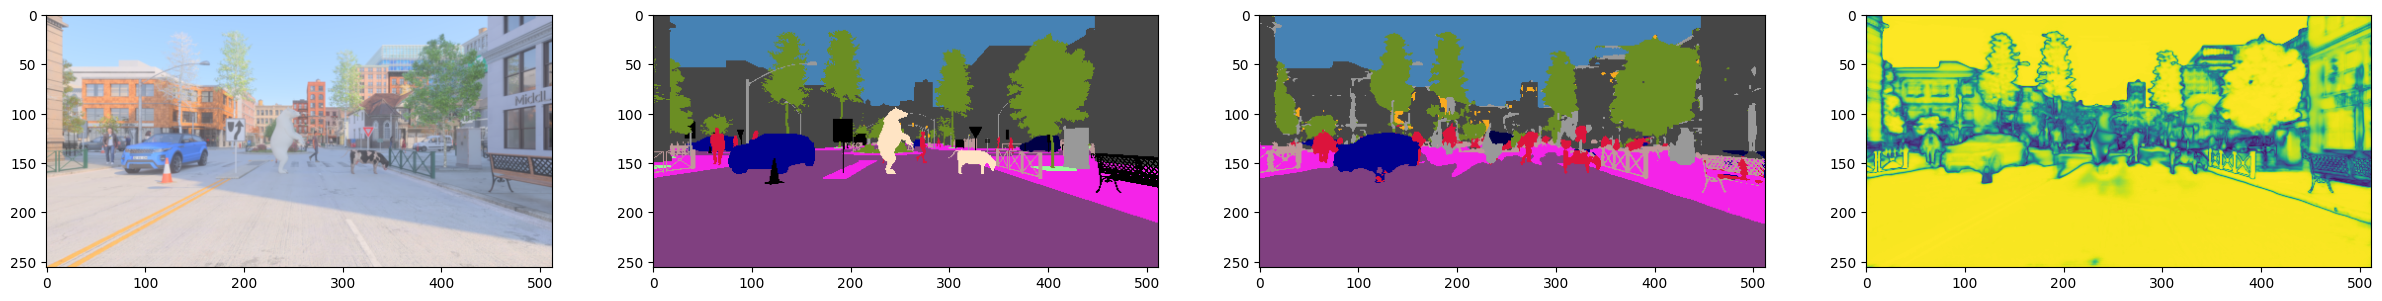

In [ ]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img_pil = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img_pil)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**Q12 bis/ According to the output is the model confident when it comes to labeling the bear and goat? How about the bench? The last image is the related to the confidence score of the DNN. Can you explain why? Are you happy with this image?**


**ANSWER:** The model does not detect the bear and the goat, which is normal because it was not trained on images with such classes. But the confidence corresponding is not that low, it is similar to the confidence for the pedestrian next by.   
The bench is rather well segmented, but labeled as a fence, and the corresponding the level of confidence is really low.

We hoped for the model top be less confident for the labeling of OOD objects, as it is for the bench.

This can be explained by the fact that the model can not understand anything that it has not seen in training phase.

## C. Uncertainty evaluations with Temperature Scaling
**Q13/ Implement a temperature scaling using torch_uncertainty.**

Before Temprature scaling.

In [ ]:
# Initialize the calibration dataset
from torch.utils.data import random_split, DataLoader

cal_dataset, test_dataset_bis, other = random_split(
    test_set, [50, 50, len(test_set) - 100]
)

test_loader_bis = DataLoader(test_dataset_bis, batch_size = batch_size)

In [ ]:
# https://github.com/ENSTA-U2IS-AI/torch-uncertainty/blob/main/auto_tutorials_source/tutorial_scaler.py
from torch_uncertainty.metrics import CalibrationError

# Initialize the ECE
ece = CalibrationError(task="multiclass", num_classes=num_classes).cuda()

# Iterate on the calibration dataloader
for sample, target in test_loader_bis:
    logits = model(sample.cuda())

    # the channel dimension for the target need to be removed, unless we get a ValueError ('The `preds` and `target` should have the same shape')
    flatten_logits =  rearrange(logits, 'b c h w -> (b h w) c')
    flatten_target = rearrange(target, 'b c h w -> (b c h w)')

    #not sure we are supposed to use the validation mask here
    valid_mask = flatten_target != 255
    target = flatten_target[valid_mask]
    flatten_logits = flatten_logits[valid_mask]

    probs = flatten_logits.softmax(1)
    ece.update(probs, target.cuda())

# Compute & print the calibration error
print(f"ECE before scaling - {ece.compute():.3%}.")

ECE before scaling - 1.762%.


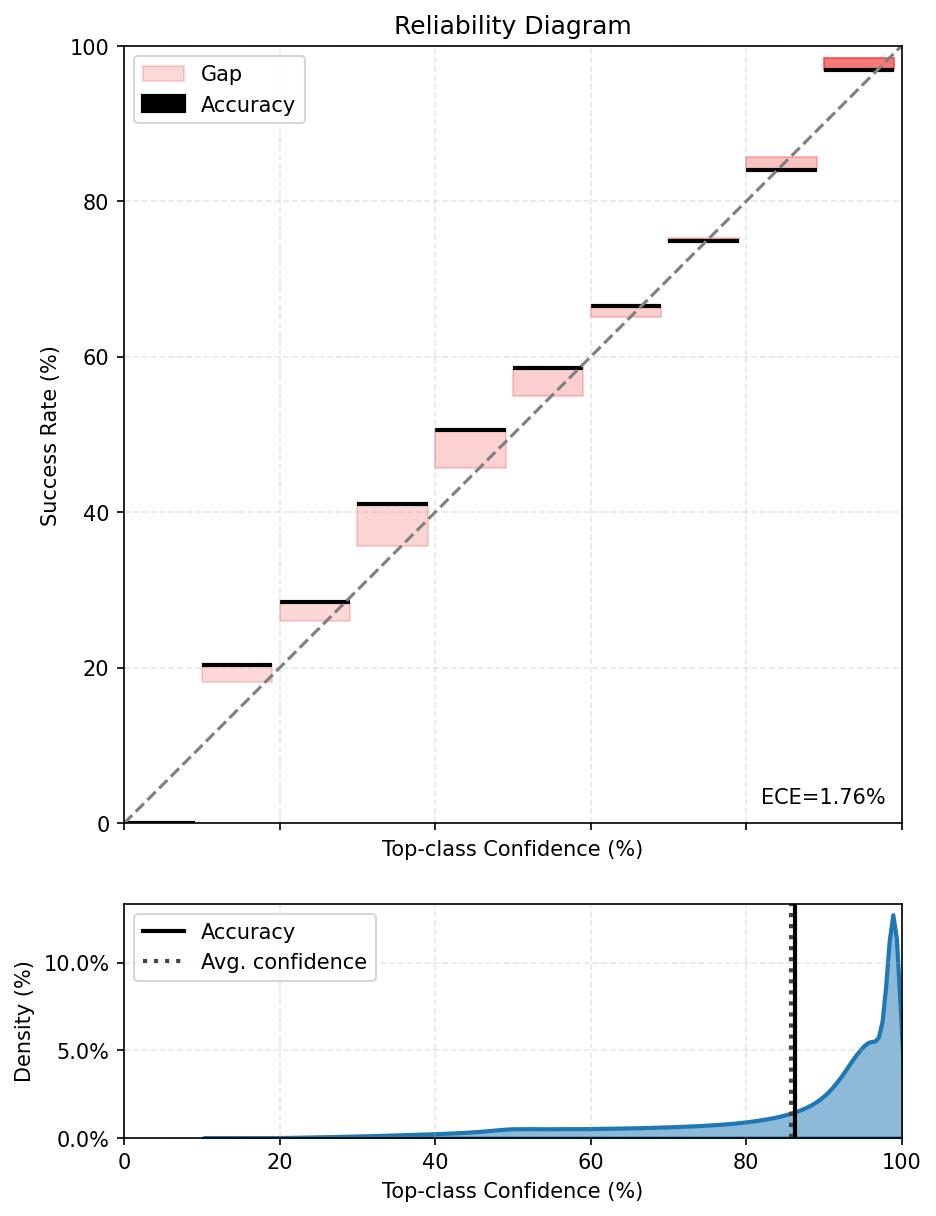

In [ ]:
# Plot the top-label calibration figure
fig, ax = ece.plot()
fig.show()

**Seeing the two graphs above comment on the MCP unceratinty result, is the model overconfident or calibrated?**

**ANSWER:** According tho this [Github page](https://github.com/hollance/reliability-diagrams) and this [article](https://arxiv.org/abs/1706.04599), deep neural networks are often not calibrated. In practice, this means that the softmax output of a classifier does not correspond to a probability or equivalently, the confidence of the model is not equal to its accuracy.

The article emphasise that for critical tasks such as autonomous driving or health care "a network should provide a calibrated confidence
measure in addition to its prediction. In other words, the
probability associated with the predicted class label should
reflect its ground truth correctness likelihood." So in the case of a low confidence score, another system (most likely a human) can take the control.

Going back to confidence score and accuracy, a good calibrated model that makes 100 predictions with a confidence score of 0.8 should have 80 % of its predictions correct and 20 % wrong. Whereas a model that is not calibrated, out of 100 predictions each with a confidence score of 0.8, can in fact have only 60 % correct predictions (in that cas it is over-confident) or 90 % correct predictions (making it an under-confident model).

Confidence histograms (bottom part in the figure above) and reliability diagrams (top part in the figure above) are great tools to assess the calibration of a model.

In the confidence diagram, test data is split into bins of same confidence score and the size of a bin's bar represents the number of test data in the bin of confidence. The average accuracy and confidence of the model are also plotted.  
In our case, the diagram is slightly different (density instead of count) we that most of the predictions of our model have a confidence score above 0.8. There is a spike meaning that a lot of predictions have a confidence score a little under 1. So the model is quite confident. But it is neither under nor over confident as the average accuracy and confidence are close togeteher (around 0.85).

The reliability diagram give even more information. The test data is still split into bins of predictions with equal confidence score. First, the black bar shows the average accuracy for the examples in each bin. Then the red bars represent the gap between accuracy and confidence for each bin.  
In our case, we have 10 bins. The 8th bin has virtually no red bar which means that for the example in this bin, the accuracy is equal to the confidence score (so the model is calibrated). Ideally, we would like to see that for each bin. But it is clearly not the case...  
The diagonal corresponds to the ideal accuracy (taht is to say the confidence as we want our model to be calibrated) for each bin of confidence (see Figure 1 of the article). So if the average accuracy is a the top of the red bar the model is not confident enough and if it is at the bottom, the model is over confident.  
Ou rmodel is well calibrated of not enough confident for the 8 first bins and it is over confident for the last two.

Looking at this plot, we see that the model is close to being calibrated. On top of that, the Expected Calibration Error (ECE, ~weighted average of confidence-accuracy gap accros all bins) is very low. We can say it is a little bit under-confident.

Note: over-confidence -> more false positive vs under-confidence -> more false negative

After temperature scaling.

In [ ]:
from torch_uncertainty.post_processing import TemperatureScaler
from tqdm import tqdm
from torch.utils.data import DataLoader

# modify fit call from class Scaler
# https://github.com/ENSTA-U2IS-AI/torch-uncertainty/blob/7d0d345a44ac6ada38372bc6dbce007a00cfeeb5/torch_uncertainty/post_processing/calibration/scaler.py#L12

def fit_adaptation(self, calibration_set, save_logits=False, progress=True):
  logits_list = []
  labels_list = []
  calibration_dl = DataLoader(calibration_set, batch_size=32, shuffle=False, drop_last=False)

  with torch.no_grad():
    for inputs, labels in tqdm(calibration_dl, disable=not progress):
      logits = self.model(inputs.to(self.device))

      flatten_logits =  rearrange(logits, 'b c h w -> (b h w) c')
      flatten_labels = rearrange(labels, 'b c h w -> (b c h w)')

      valid_mask = flatten_labels != 255
      labels = flatten_labels[valid_mask]
      flatten_logits = flatten_logits[valid_mask]

      logits_list.append(flatten_logits)
      labels_list.append(labels)

  all_logits = torch.cat(logits_list).detach().to(self.device)
  all_labels = torch.cat(labels_list).detach().to(self.device)

  optimizer = torch.optim.LBFGS(self.temperature, lr=self.lr, max_iter=self.max_iter)

  def calib_eval():
    optimizer.zero_grad()
    loss = self.criterion(self._scale(all_logits), all_labels)
    loss.backward()
    return loss

  optimizer.step(calib_eval)
  self.trained = True

  if save_logits:
    self.logits = all_logits
    self.labels = all_labels

TemperatureScaler.fit = fit_adaptation

In [ ]:
# Fit the scaler on the calibration dataset
scaled_model = TemperatureScaler(model=model, device="cuda")

scaled_model.train()
scaled_model.fit(calibration_set=cal_dataset)

100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.29s/it]


In [ ]:
# Reset the ECE
ece.reset()

# Iterate on the calibration dataloader
for sample, target in test_loader_bis:
    logits = scaled_model(sample.cuda())

    flatten_logits =  rearrange(logits, 'b c h w -> (b h w) c')
    flatten_target = rearrange(target, 'b c h w -> (b c h w)')

    valid_mask = flatten_target != 255
    target = flatten_target[valid_mask]
    flatten_logits = flatten_logits[valid_mask]

    probs = flatten_logits.softmax(-1)

    ece.update(probs, target.cuda())

# Compute & print the calibration error
print(f"ECE after scaling - {ece.compute():.3%}.")

ECE after scaling - 3.228%.


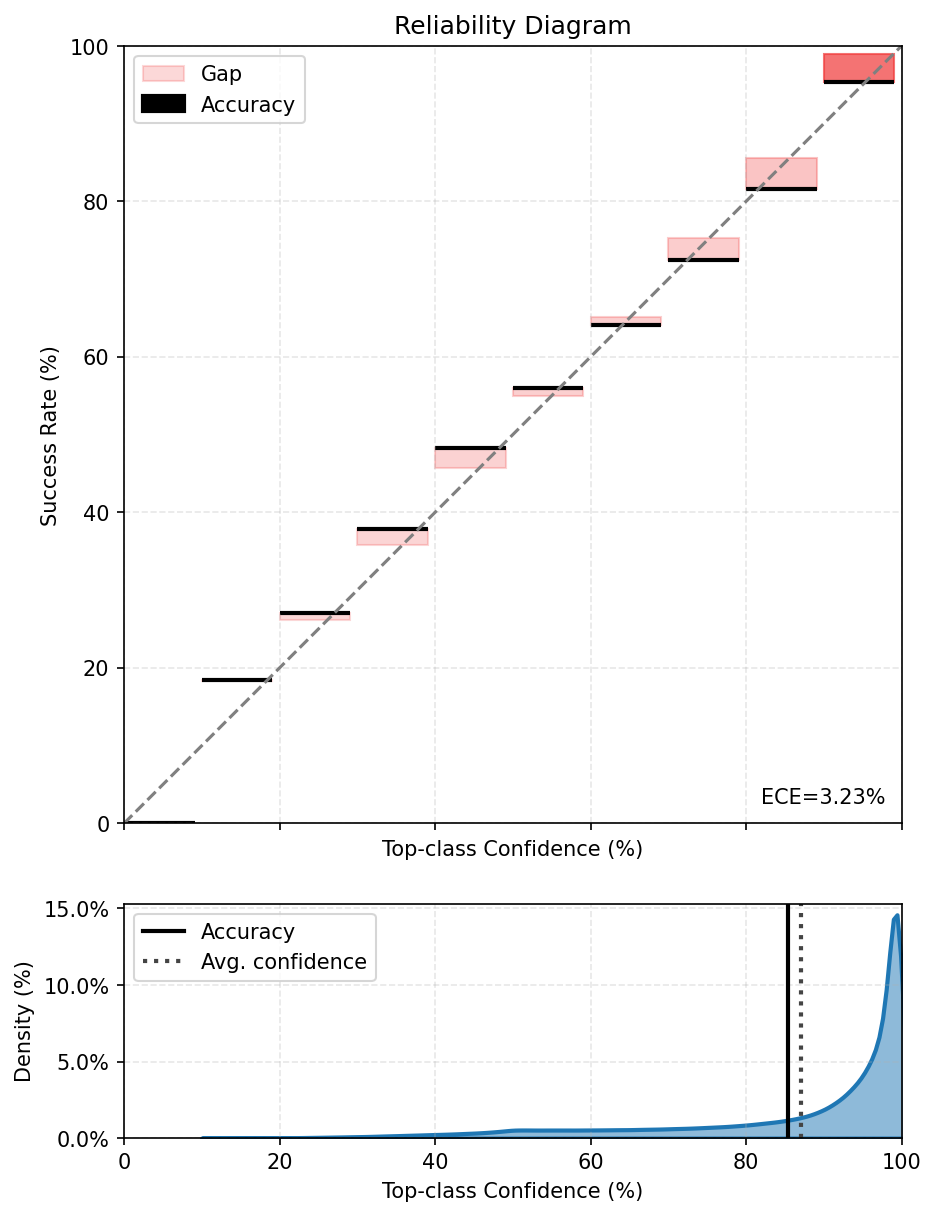

In [ ]:
# Plot the top-label calibration figure
fig, ax = ece.plot()
fig.show()

Now let's see the new confidence score image after scaling.

In [ ]:
sample_idx = 0
img, target = test_ood_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
scaled_model.eval()
with torch.no_grad():
	# Forward propagation
	outputs = scaled_model(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	# remove the batch dimension
	outputs_proba = outputs_proba.squeeze(0)
	confidence, pred = outputs_proba.max(0)

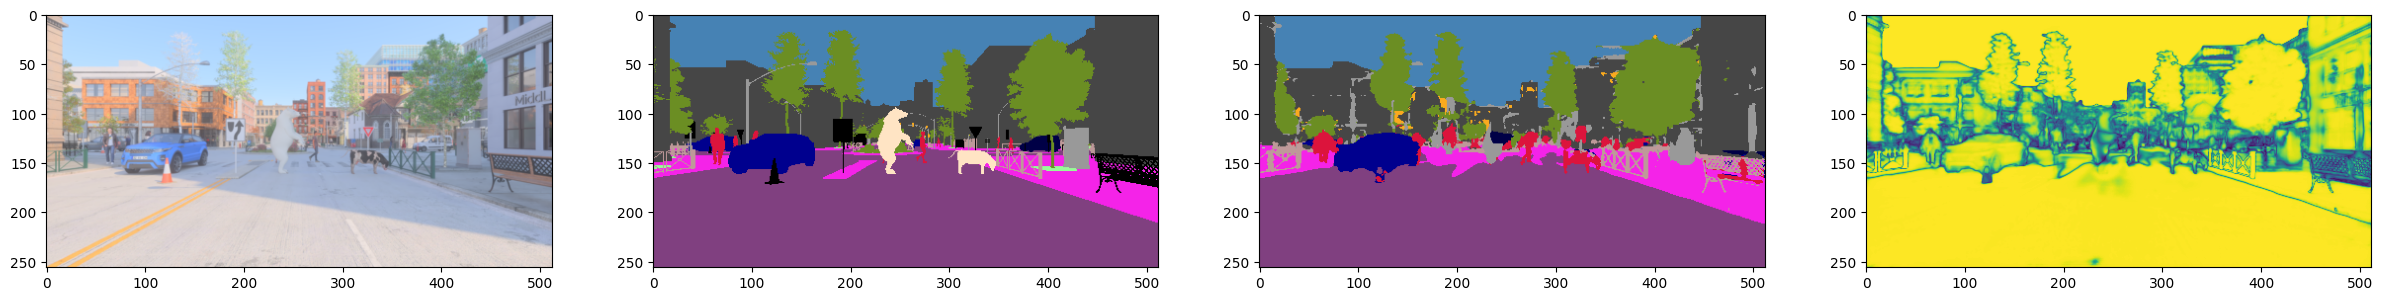

In [ ]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img_pil = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img_pil)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**Did the model get more confident or is it more calibrated? Comment on the temperature scaling graphs and results.**

**ANSWER:** Our understanding is that temperature scaling is a method to calibrate a model. However, results on our models show that it is actually less calibrated than before. For instance, the ECE increased.

It is important to note that bins where the confidence was lower than the accuracy (the 7 first bins) have seen the gap decrease. This means that the model is more calibrated for these bins which is great. What is not as good, is the fact that the gap increased for the last 3 bins making the model even more over-confident...

We did not notice any meaningful change in the prediction and confidence of our model on the test image.

## D. Uncertainty evaluations with MC Dropout

Let us implement **MC dropout**. This technique decribed in [this paper](https://arxiv.org/abs/1506.02142) allow us to have a better confindence score by using the dropout during test time.



**Q14/ Implement MC Dropout using torch_uncertainty.**

In [ ]:
# https://github.com/ENSTA-U2IS-AI/torch-uncertainty/blob/main/torch_uncertainty/datamodules/segmentation/muad.py
from torch_uncertainty.datamodules import TUDataModule

class MUADSmallDataModule(TUDataModule):

  def __init__(
        self,
        root: str,
        batch_size: int,
        train_transform,
        val_transform,
        num_workers: int = 1,
        pin_memory: bool = True,
        persistent_workers: bool = True,
    ) -> None:

        super().__init__(
            root=root,
            batch_size=batch_size,
            val_split=None,
            num_workers=num_workers,
            pin_memory=pin_memory,
            persistent_workers=persistent_workers,
        )

        self.dataset = MUAD

        self.train_transform = train_transform
        self.test_transform = val_transform

  def prepare_data(self) -> None:
      self.dataset(root=self.root, target_type="semantic", version="small", split="train" )
      self.dataset(root=self.root, target_type="semantic", version="small", split="val" )

  def setup(self, stage: str | None = None) -> None:
      if stage == "fit" or stage is None:
          full = self.dataset(
              root=self.root,
              split="train",
              target_type="semantic",
              transforms=self.train_transform,
              version="small",
          )

          self.train = full
          self.val = self.dataset(
              root=self.root,
              split="val",
              target_type="semantic",
              transforms=self.test_transform,
              version="small",
          )

      if stage == "test" or stage is None:
          self.test = self.dataset(
              root=self.root,
              split="test",
              target_type="semantic",
              transforms=self.test_transform,
              version="small",
          )

      if stage not in ["fit", "test", None]:
          raise ValueError(f"Stage {stage} is not supported.")

In [ ]:
# https://github.com/ENSTA-U2IS-AI/torch-uncertainty/blob/main/auto_tutorials_source/tutorial_mc_dropout.py
from torch_uncertainty.models.wrappers.mc_dropout import mc_dropout
from torch_uncertainty.routines import ClassificationRoutine
from torch_uncertainty import TUTrainer
from torch.optim import lr_scheduler, Adam

torch.cuda.empty_cache()


data_module = MUADSmallDataModule(root="./data", batch_size=batch_size, train_transform=train_transform, val_transform=val_transform, num_workers=2)

trainer = TUTrainer(accelerator="gpu", max_epochs=2, enable_progress_bar=False)
mc_model = mc_dropout(model, num_estimators=6, last_layer=False).cuda()

optim = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = lr_scheduler.StepLR(optim, step_size=lr_decay_epochs, gamma=lr_decay)
optim_recipe = {"optimizer": optim, "lr_scheduler": lr_scheduler}

routine = ClassificationRoutine(
    num_classes=num_classes,
    model=mc_model,
    loss=nn.CrossEntropyLoss(ignore_index=255),
    optim_recipe=optim_recipe,
    is_ensemble=True,
)

trainer.fit(model=routine, datamodule=data_module)
results = trainer.test(model=routine, datamodule=test_loader)

/home/ids/jmalecot-21/anaconda3/envs/muadenv/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/jmalecot-21/anaconda3/envs/muadenv/lib/pyt ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type             | Params | Mode 
-----------------------------------------------------------------
0 | model               | MCDropout        | 3.7 M  | train
1 | loss                | CrossEntropyLoss | 0      | train
2 | format_batch_fn     | Identity         | 0      | train
3 | val_cls_metrics     | MetricCollection | 0      | train
4 | test_cls_metrics    | MetricCollection | 0      | train
5 | test_id_entropy     | Entropy          | 0      |

EinopsError:  Error while processing rearrange-reduction pattern "(m b) c -> b m c".
 Input tensor shape: torch.Size([60, 19, 256, 512]). Additional info: {'b': 10}.
 Wrong shape: expected 2 dims. Received 4-dim tensor.

In [ ]:
mc_model_path = "mc.pth"
torch.save(mc_model.state_dict(), mc_model_path)
print(f"Model saved to {mc_model_path}")

NameError: name 'ens_model' is not defined

In [ ]:
sample_idx = 0
img, target = test_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
mc_model.eval()
with torch.no_grad():
    # Forward propagation
    outputs = mc_model(batch_img)
    outputs_proba = outputs.softmax(dim=1)
    # remove the batch dimension
    outputs_proba = outputs_proba.squeeze(0)
    max_outputs_proba, _ = outputs_proba.max(1)
    confidence, pred = max_outputs_proba.max(0)

In [ ]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]
pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img_pil = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img_pil)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**Try the MC dropout code with a low number of estimators T like 3 and a high number 20. Explain the diffrence seen on the confidence image. Is the model getting more confident or less?**

**ANSWER:**

## E. Uncertainty evaluations with Deep Ensembles
**Q15/ Implement [Deep Ensembles](https://papers.nips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf).**


1.   You need to train 3 DNNs and save it. (Go back to the training cell above and train and save 3 diffrent models)
2.   Use TorchUncertainty to get predictions

You have two options either train several models using the code above or use TU to train the ensemble of models in parallel.

In [ ]:
from torch_uncertainty.models import deep_ensembles
from torch_uncertainty.routines import ClassificationRoutine
from torch_uncertainty import TUTrainer

ens_model = deep_ensembles(model, num_estimators=16).cuda()

ens_routine = ClassificationRoutine(
    num_classes=n_classes,
    model=ens_model,
    loss=nn.CrossEntropyLoss(),
    # optim_recipe=optim_cifar10_resnet18(mc_model), # ???
    is_ensemble=True,
)

ens_trainer = TUTrainer(accelerator="gpu", max_epochs=2, enable_progress_bar=False)
ens_trainer.fit(model=ens_routine, datamodule=train_loader)
results = trainer.test(ens_routine, test_loader)

Test your ensemble obtained either using option 1 or 2.

In [ ]:
results = trainer.test(ens_routine, test_loader)

Save the ensemble model.

In [ ]:
final_model_path = "ensemble.pth"
torch.save(ensemble.state_dict(), final_model_path)
print(f"Model saved to {final_model_path}")

## F. Uncertainty evaluations with Packed-Ensembles
**Q15/ Read [Packed-Ensembles](https://arxiv.org/pdf/2210.09184). Then Implement a Packed-Ensembles Unet and train it and evaluate its Uncertainty.**


**Please conclude your report.**

